In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('airbnb_london_clean.csv')
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,bedrooms,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat
0,121.122322,Private room,False,True,2.0,False,0,0,6.0,69.0,1,5.734117,0.437094,222.882243,15.493414,470.088502,8.413765,-0.04975,51.52570
1,195.912416,Private room,False,True,2.0,False,1,0,10.0,96.0,1,4.788905,1.464050,235.385841,16.362588,530.133525,9.488466,-0.08475,51.54210
2,193.325337,Private room,False,True,3.0,False,1,0,10.0,95.0,1,4.596677,0.450306,268.913812,18.693247,548.987610,9.825922,-0.14585,51.54802
3,180.389943,Private room,False,True,2.0,False,1,0,9.0,87.0,1,2.054769,0.132670,472.381314,32.837067,1021.271062,18.278973,-0.10611,51.52108
4,405.700981,Entire home/apt,False,False,3.0,False,0,1,7.0,65.0,0,4.491277,0.354108,318.491470,22.139584,692.775411,12.399473,-0.18797,51.49399


Для кластерного аналізу візьмемо 2 змінні, а саме нормалізований індекс привабливості (0-100) **attr_index_norm** та нормалізований індекс ресторанів (0-100) **rest_index_norm**.

In [3]:
X = df.iloc[:, [14, 16]].values

***Кластеризація методом K-середніх***

Знайдемо оптимальну кількість кластерів за допомогою методу ліктя.

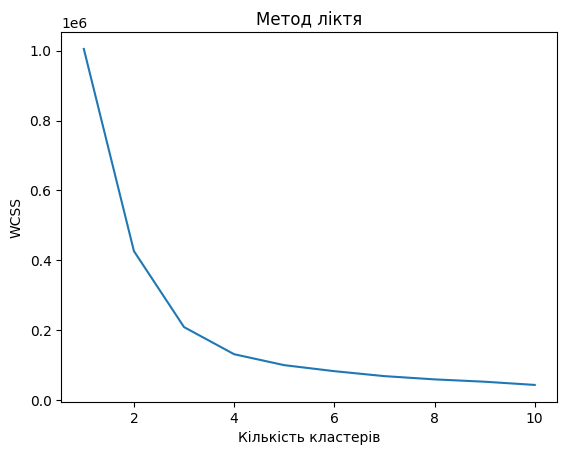

In [12]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
  kmeans.fit(X)
  wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Метод ліктя')
plt.xlabel('Кількість кластерів')
plt.ylabel('WCSS')
plt.show()

Бачимо, що графік дуже стрімко спадає по шкалі кількості кластерів з 1 до 2. Також різко спадає з 2 до 3, а от починаючи з 3 до 4 графік спадає не так різко і зміни не такі критичні. Враховуючи той факт, що в ідеалі потрібно взяти якомога менше кластерів, то оптимальним рішенням в цій ситуації буде розбити дані на 3 кластери.

Тренуємо наш алгоритм кластеризації для 3 кластерів.

In [19]:
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X)

Таблиця з координатами центроїд та кількістю елементів по кожному кластеру

In [28]:
centroids = kmeans.cluster_centers_
cluster_counts = np.bincount(y_kmeans)
cluster_data = {
    'Кластер': [f'Кластер {i+1}' for i in range(len(centroids))],
    'Центроїда X': centroids[:, 0],
    'Центроїда Y': centroids[:, 1],
    'Кількість елементів': cluster_counts
}
cluster_table = pd.DataFrame(cluster_data)
cluster_table

,Кластер,Центроїда X,Центроїда Y,Кількість елементів
0,Кластер 1,13.569555,7.532008,3349
1,Кластер 2,59.403670,34.693282,215
2,Кластер 3,28.593690,15.132794,1811


Візуалізація кластерів

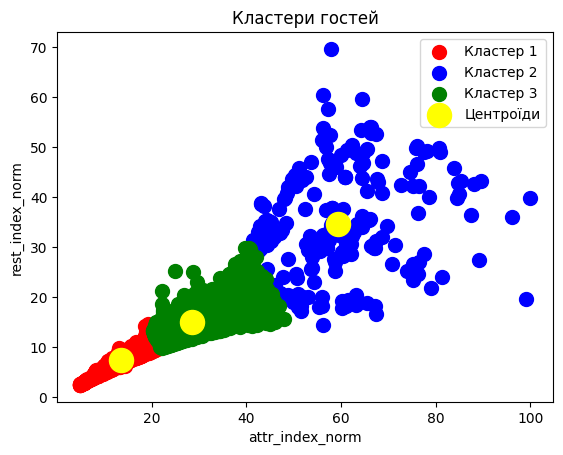

In [29]:
plt.scatter(X[y_kmeans == 0, 0], X[y_kmeans == 0, 1], s = 100, c = 'red', label = 'Кластер 1')
plt.scatter(X[y_kmeans == 1, 0], X[y_kmeans == 1, 1], s = 100, c = 'blue', label = 'Кластер 2')
plt.scatter(X[y_kmeans == 2, 0], X[y_kmeans == 2, 1], s = 100, c = 'green', label = 'Кластер 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s = 300, c = 'yellow', label = 'Центроїди')
plt.title('Кластери гостей')
plt.xlabel('attr_index_norm')
plt.ylabel('rest_index_norm')
plt.legend()
plt.show()

***Ієрархічна кластеризація***

Побудуємо дендограму і знайдемо оптимальну кількість кластерів.

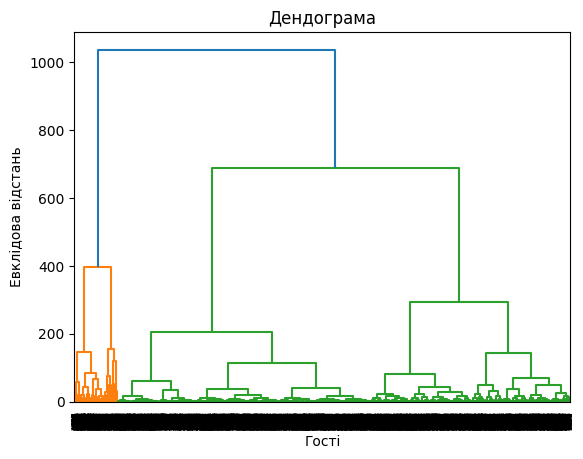

In [32]:
import scipy.cluster.hierarchy as sch
dendrogram = sch.dendrogram(sch.linkage(X, method = 'ward'))
plt.title('Дендограма')
plt.xlabel('Гості')
plt.ylabel('Евклідова відстань')
plt.show()

За дендограмою бачимо, що вище 400 по осі У Евклідова відстань між кластерами, які ми об'єднуємо, стала набагато більше, ніж раніше. Тому трішки вище 400 по осі У можемо провести пряму паралельну осі Х і побачимо, що вона перетинає три лінії, тобто об'єднання ТРЬОХ кластерів, тому і дані наші будемо розбивати теж на ТРИ кластери.

Тренуємо наш алгоритм ієрархічної кластеризації для 3 кластерів.

In [33]:
from sklearn.cluster import AgglomerativeClustering
hc = AgglomerativeClustering(n_clusters = 3, metric = 'euclidean', linkage = 'ward')
y_hc = hc.fit_predict(X)

Таблиця з кількістю елементів в кожному кластері

In [35]:
df['Cluster'] = y_hc
cluster_counts = df['Cluster'].value_counts().sort_index()
cluster_table = pd.DataFrame([cluster_counts], index=['Кількість елементів'])
cluster_table.columns = [f'Кластер {i+1}' for i in cluster_table.columns]
cluster_table

,Кластер 1,Кластер 2,Кластер 3
Кількість елементів,465,2166,2744


Візуалізація кластерів

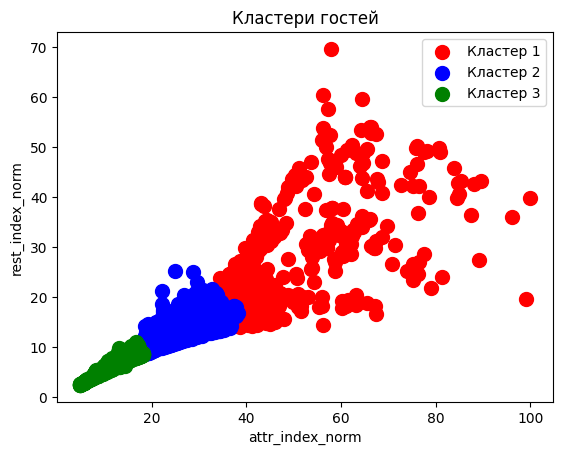

In [36]:
plt.scatter(X[y_hc == 0, 0], X[y_hc == 0, 1], s = 100, c = 'red', label = 'Кластер 1')
plt.scatter(X[y_hc == 1, 0], X[y_hc == 1, 1], s = 100, c = 'blue', label = 'Кластер 2')
plt.scatter(X[y_hc == 2, 0], X[y_hc == 2, 1], s = 100, c = 'green', label = 'Кластер 3')
plt.title('Кластери гостей')
plt.xlabel('attr_index_norm')
plt.ylabel('rest_index_norm')
plt.legend()
plt.show()

Отже, порівнюючи отримані графіки та дані під час кластеризації методом **К-середніх** та **ієрархічним**, бачимо, що обидва алгоритми чудово впоралися із своєю задачею. Фактично розподіл майже однаковий в першому і в другому алгоритмі (Усюди використовувалася Евклідова відстань).


